In [2]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## Loading Data Incendie


In [4]:
df_incendie= pd.read_csv('./Data/Incendies.csv', sep=';', header=3)
df_incendie.shape

(27785, 24)

In [5]:
df_incendie.columns

Index(['Année', 'Numéro', 'Département', 'Code INSEE', 'Nom de la commune',
       'Date de première alerte', 'Surface parcourue (m2)',
       'Surface forêt (m2)', 'Surface maquis garrigues (m2)',
       'Autres surfaces naturelles hors forêt (m2)', 'Surfaces agricoles (m2)',
       'Autres surfaces (m2)', 'Surface autres terres boisées (m2)',
       'Surfaces non boisées naturelles (m2)',
       'Surfaces non boisées artificialisées (m2)',
       'Surfaces non boisées (m2)', 'Précision des surfaces',
       'Type de peuplement', 'Nature', 'Décès ou bâtiments touchés',
       'Nombre de décès', 'Nombre de bâtiments totalement détruits',
       'Nombre de bâtiments partiellement détruits', 'Précision de la donnée'],
      dtype='object')

In [6]:
colonnes_utiles = [
    'Année',
    'Numéro',
    'Département',
    'Code INSEE',
    'Date de première alerte',
    'Surface parcourue (m2)',  
    'Surface forêt (m2)',
    'Surface maquis garrigues (m2)',
    'Autres surfaces naturelles hors forêt (m2)',
    'Surface autres terres boisées (m2)',
    'Surfaces non boisées naturelles (m2)',
    'Surfaces non boisées artificialisées (m2)',
    'Surfaces non boisées (m2)'
]

incendie = df_incendie[colonnes_utiles].copy()


In [7]:
incendie.head(1)

,Année,Numéro,Département,Code INSEE,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2)
0,2015,5769,66,66100,2015-01-01 00:09:00,5000,5000.0,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning Data Incendie

In [9]:
incendie.isna().any()

Année                                         False
Numéro                                        False
Département                                   False
Code INSEE                                    False
Date de première alerte                       False
Surface parcourue (m2)                        False
Surface forêt (m2)                             True
Surface maquis garrigues (m2)                  True
Autres surfaces naturelles hors forêt (m2)     True
Surface autres terres boisées (m2)             True
Surfaces non boisées naturelles (m2)           True
Surfaces non boisées artificialisées (m2)      True
Surfaces non boisées (m2)                      True
dtype: bool

In [10]:
incendie.fillna(0, inplace=True)

In [11]:
# On fusionne les surfaces forêt + autres terres boisées, et les surfaces non boisées naturelles + artificialisées, pour créer des indicateurs synthétiques de type de terrain
incendie.iloc[:,6] = incendie.iloc[:,6] + incendie.iloc[:,7]
incendie.iloc[:,9] = incendie.iloc[:,9] + incendie.iloc[:,10]

In [12]:
# Suppression des colonnes redondantes après fusion manuelle des surfaces boisées et non boisées
incendie.drop(['Surface autres terres boisées (m2)','Surfaces non boisées (m2)'], axis=1, inplace=True)

In [13]:
incendie.rename(columns={
    'Année': 'annee',
    'Numéro': 'id_inc',
    'Département': 'dep',
    'Code INSEE': 'code_insee',
    'Date de première alerte': 'date',
    'Surface parcourue (m2)': 'surf_brulee',
    'Surface forêt (m2)': 'surf_foret',
    'Surface maquis garrigues (m2)': 'surf_maquis',
    'Autres surfaces naturelles hors forêt (m2)': 'autre_surf',
    'Surface autres terres boisées (m2)': 'surf_autres_bois',
    'Surfaces non boisées naturelles (m2)': 'surf_nb_naturelle',
    'Surfaces non boisées artificialisées (m2)': 'surf_nb_artificielle',
    'Surfaces non boisées (m2)': 'surf_nb_totale'
}, inplace=True)

In [14]:
incendie.shape

(27785, 11)

In [15]:
incendie.drop_duplicates(['date','id_inc']).shape

(27785, 11)

In [16]:
incendie.drop_duplicates(['code_insee','id_inc']).shape

(27756, 11)

In [17]:
incendie.dtypes

annee                     int64
id_inc                    int64
dep                      object
code_insee               object
date                     object
surf_brulee               int64
surf_foret              float64
surf_maquis             float64
autre_surf              float64
surf_nb_naturelle       float64
surf_nb_artificielle    float64
dtype: object

In [18]:
# On enlève les départements corses
incendie = incendie[~incendie['code_insee'].astype(str).str.startswith(('2A', '2B'))]

In [19]:
# On convertit la colonne code_insee en entier
incendie['code_insee'] = incendie['code_insee'].astype(int)

In [20]:
# Regroupement des départements d’Île-de-France sous le code de Paris ('75'), comme dans les données IGN sauf pour la Seine-et-Marne 
incendie.loc[
    (incendie.dep == '75') |
    (incendie.dep == '91') |
    (incendie.dep == '92') |
    (incendie.dep == '93') |
    (incendie.dep == '94') |
    (incendie.dep == '95') |
    (incendie.dep == '78'),
    'dep'
] = '75'

In [21]:
# Convertir les dates en datetime
incendie['date'] = incendie.date.apply(lambda _: dt.datetime.strptime(_,"%Y-%m-%d %H:%M:%S"))

## Loading Geographic Data

In [23]:
coords= gpd.read_file('./Data/commune.shp')

In [24]:
# Affichage du nombre de communes et des colonnes disponibles dans le shapefile AdminExpress
coords.shape, coords.columns

((34935, 12),
 Index(['ID', 'NOM', 'NOM_M', 'INSEE_COM', 'STATUT', 'POPULATION', 'INSEE_CAN',
        'INSEE_ARR', 'INSEE_DEP', 'INSEE_REG', 'SIREN_EPCI', 'geometry'],
       dtype='object'))

In [25]:
coords = coords[['INSEE_COM', 'INSEE_DEP', 'geometry']].copy()
coords.columns = ['code_insee', 'dep', 'geometry']

In [26]:
# On sélectionne les colonnes utiles et on harmonise le code INSEE au format chaîne de 5 caractères
coords['code_insee'] = coords['code_insee'].astype(str).str.zfill(5)

In [27]:
coords.loc[(coords.dep=='75')|(coords.dep=='91')|(coords.dep=='92')|(coords.dep=='93')|(coords.dep=='94')|(coords.dep=='95')|(coords.dep=='78'), 'dep'] = '75'

In [28]:
# Harmonisation des code_insee dans le dataset incendie
incendie['code_insee'] = incendie['code_insee'].astype(str).str.zfill(5)

# Affichage des communes non matchées
incendie[~incendie['code_insee'].isin(coords['code_insee'])]


,annee,id_inc,dep,code_insee,date,surf_brulee,surf_foret,surf_maquis,autre_surf,surf_nb_naturelle,surf_nb_artificielle
118,2015,6934,48,48122,2015-02-18 14:30:00,12500,6000.0,0.0,0.0,0.0,0.0
189,2015,11315,48,48162,2015-03-07 21:30:00,10005,0.0,0.0,0.0,0.0,0.0
201,2015,10983,48,48022,2015-03-08 15:40:00,114600,114600.0,114600.0,0.0,0.0,0.0
212,2015,10961,48,48022,2015-03-09 13:02:00,138000,138000.0,138000.0,0.0,0.0,0.0
233,2015,10818,11,11097,2015-03-10 15:53:00,2000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
22174,2022,2504,71,71492,2022-07-31 13:10:00,5000,0.0,0.0,5000.0,0.0,0.0
22237,2022,17749,05,05141,2022-08-02 09:23:00,13130,1330.0,230.0,0.0,0.0,0.0
22361,2022,17967,48,48184,2022-08-04 15:45:00,90000,90000.0,90000.0,0.0,0.0,0.0
22702,2022,18092,48,48154,2022-08-10 14:13:00,150,150.0,150.0,0.0,0.0,0.0


In [29]:
# Nombre de communes sans correspondance géographique
len(incendie[~incendie.code_insee.isin(coords.code_insee)])

190

In [30]:
# Date de la première alerte
incendie.date.dt.year.min()

2015

## Loading Data Forêt

In [32]:
arbre = pd.read_csv("./Data/COUVERT.csv", sep=";", low_memory=False)

In [33]:
arbre.shape, arbre.columns

((750822, 9),
 Index(['CAMPAGNE', 'IDP', 'STRATE', 'ESPAR_C', 'TCA', 'TCL', 'P1525', 'P7ARES',
        'Unnamed: 8'],
       dtype='object'))

In [34]:
arbre.sort_values(['IDP','TCA'], inplace=True)

In [35]:
ign = arbre[['IDP', 'ESPAR_C']].drop_duplicates('IDP', keep='last').copy()

In [36]:
ign.columns = ['idp', 'essence']
ign.shape

(110459, 2)

In [37]:
ign.set_index('idp', inplace=True)

## Cleaning Data Forêt

In [39]:
ign.reset_index(inplace=True)
ign.isna().any()

idp        False
essence    False
dtype: bool

In [40]:
# valeurs NaN venant d'un dataset original?
arbre.isna().any()

CAMPAGNE      False
IDP           False
STRATE        False
ESPAR_C       False
TCA           False
TCL           False
P1525          True
P7ARES         True
Unnamed: 8     True
dtype: bool

## Loading Data Météo

In [42]:
station= pd.read_csv('./Data/meteo_station.txt', sep=';')

In [43]:
station.shape[0] - len(station.ID.drop_duplicates())

0

In [44]:
station.head(1)

,ID,Nom,Latitude,Longitude,Altitude
0,7005,ABBEVILLE,50.136,1.834,69


In [45]:
station.drop(['Nom', 'Altitude'], axis=1, inplace=True)

In [46]:
station.columns = station.columns.str.lower()

In [47]:
geometry = gpd.points_from_xy(station.longitude, station.latitude)
crs = 'epsg:4326'

stations = gpd.GeoDataFrame(station, geometry=geometry, crs=crs)

In [48]:
stations.set_crs(epsg=4326, inplace=True, allow_override=True)
coords.set_crs(epsg=4326, inplace=True, allow_override=True)

stations = stations.to_crs(epsg=2154)
coords = coords.to_crs(epsg=2154)



In [49]:
# test de proximité entre Point(Stations) et Polygone(Coords_fr)
stations = gpd.sjoin_nearest(coords, stations)
stations.head(1)

,code_insee,dep,geometry,index_right,id,latitude,longitude
0,29067,29,"POLYGON ((213580.3 6849033.2, 213591.6 6848979...",7,7117,48.825833,-3.473167


In [50]:
# récupération des codes départementaux via le code INSEE
stations['dep_insee'] = stations.code_insee.apply(lambda _: _[:2])

In [51]:
# changement pour les départements d'Île-de-France en 75
stations.loc[(stations.dep_insee=='75')|(stations.dep_insee=='91')|(stations.dep_insee=='92')|(stations.dep_insee=='93')|(stations.dep_insee=='94')|(stations.dep_insee=='95')|(stations.dep_insee=='78'), 'dep_insee'] = '75'

In [52]:
# différence entre "dep" et le département du code INSEE?
stations[stations.dep_insee!=stations.dep.astype(str)]

,code_insee,dep,geometry,index_right,id,latitude,longitude,dep_insee
34806,97110,971,"MULTIPOLYGON (((-6222575.57 6081172.109, -6222...",52,78890,16.335000,-61.004000,97
34807,97114,971,"MULTIPOLYGON (((-6281930.798 6110794.953, -628...",54,78897,16.264000,-61.516333,97
34808,97119,971,"POLYGON ((-6238971.15 6123966.423, -6238971.18...",54,78897,16.264000,-61.516333,97
34809,97124,971,"POLYGON ((-6305588.814 6112702.415, -6305587.2...",54,78897,16.264000,-61.516333,97
34810,97109,971,"POLYGON ((-6297024.531 6111938.047, -6297046.5...",54,78897,16.264000,-61.516333,97
...,...,...,...,...,...,...,...,...
34930,97358,973,"POLYGON ((-6604138.273 4177665.52, -6604368.73...",58,81405,4.822333,-52.365333,97
34931,97312,973,"MULTIPOLYGON (((-6508825.476 4300634.146, -650...",58,81405,4.822333,-52.365333,97
34932,97356,973,"POLYGON ((-6659948.979 4096555.217, -6658105.8...",59,81408,3.890667,-51.804667,97
34933,97361,973,"MULTIPOLYGON (((-6526130.287 4423842.842, -652...",57,81401,5.485500,-54.031667,97


In [53]:
# réorganisation du df Stations
stations.drop(['Latitude', 'Longitude', 'index_right','geometry'], axis=1, inplace=True)
stations.insert(2,'id',stations.pop('id'))

KeyError: "['Latitude', 'Longitude'] not found in axis"

In [ ]:
stations.head(1)

In [ ]:
# raccord des id.Stations à Incendie
incendie = incendie.merge(stations[['code_insee','id']], on='code_insee', how='left')

## Météo

In [ ]:
meteo_ = pd.read_csv('./Data/meteo.csv')
meteo_.shape

In [ ]:
meteo_.head(10)

## MODEL


## Prédiction gravité d'un incendie.
# Prédire la surface qu’un feu va brûler dès qu’il est détecté, pour mieux réagir, comprendre et anticiper
# Estimer l’impact potentiel d’un incendie dès son départ, grâce au variable que sont les 'Surface forêt (m2)': 'surf_foret',
    'Surface autres terres boisées (m2)': 'surf_autres_bois',
    'Surfaces non boisées naturelles (m2)': 'surf_nb_naturelle',
    'Surfaces non boisées artificialisées (m2)': 'surf_nb_artificielle',
    'Surfaces non boisées (m2)': 'surf_nb_totale

# Ces caractéristiques incluent :
Le lieu : dep, code_insee

Le type de surface :

forêt → feu peut s’étendre

sol artificiel → moins inflammable

La date : mois, jour → influence météo, sécheresse

=> Tous ces éléments permettent d’estimer la gravité possible du feu.

Tu anticipes donc l’impact potentiel, dès le déclenchement du feu, même avant d’avoir tout brûlé.



In [54]:
df = incendie.copy()
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day
df['dayofweek'] = pd.to_datetime(df['date']).dt.dayofweek

X = df[['dep', 'code_insee', 'surf_foret',
        'surf_nb_naturelle', 'surf_nb_artificielle',
      'month', 'day', 'dayofweek']].copy()

y = df['surf_brulee']

from sklearn.preprocessing import LabelEncoder
for col in ['dep', 'code_insee']:
    X[col] = LabelEncoder().fit_transform(X[col])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Modèle simple
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Prédictions
y_pred_lin = linreg.predict(X_test)

# Évaluation
print("Linear Regression")
print("Mean absolute Error:", mean_absolute_error(y_test, y_pred_lin))
print("R²:", r2_score(y_test, y_pred_lin))


Linear Regression
Mean absolute Error: 19320.848664393285
R²: 0.9875358413127271


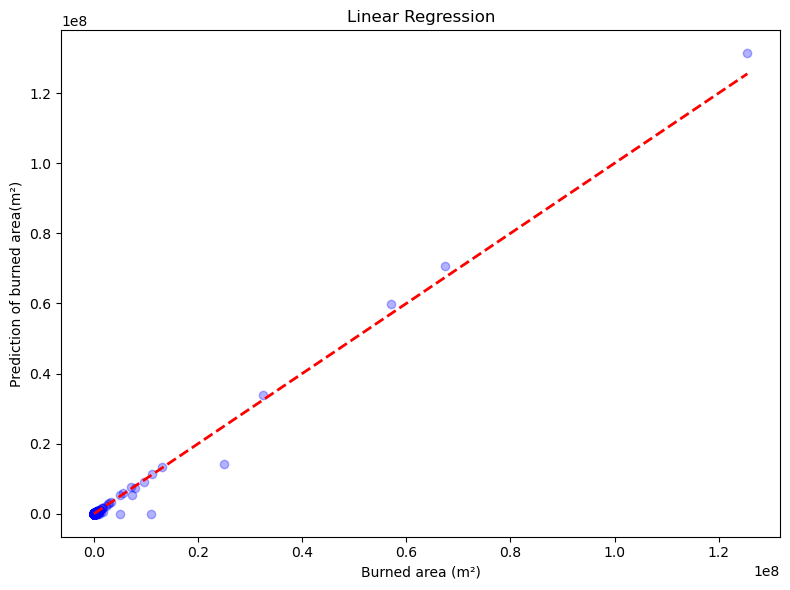

In [71]:
import matplotlib.pyplot as plt


y_pred_lin = linreg.predict(X_test)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lin, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Burned area (m²)")
plt.ylabel("Prediction of burned area(m²)")
plt.title("Linear Regression")
plt.tight_layout()
plt.show()


In [73]:
from sklearn.ensemble import RandomForestRegressor

# Modèle avancé
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf.predict(X_test)

# Évaluation
print("Random Forest Regressor")
print("Mean absolute Error:", mean_absolute_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))


Random Forest Regressor
Mean absolute Error: 37985.577953269574
R²: 0.7710278508512041


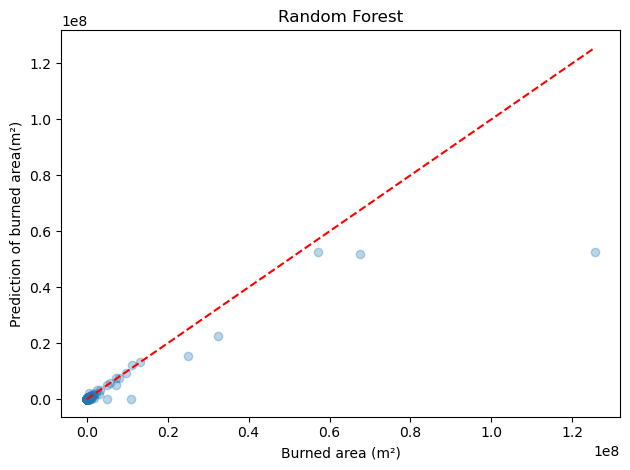

In [79]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.xlabel("Burned area (m²)")
plt.ylabel("Prediction of burned area(m²)")
plt.title("Random Forest")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()
